# MODEL:1 _XGBOOST_WEEK-1

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import sys
sys.path.append("../src/data/") # The path to the directory where split_dataset.py is located

from split_dataset import split_train_val # If split_train_val is a function in split_dataset.py
from absolutevalues import replace_negative_with_abs


sys.path.append("../src/features")
from newcol_feature import create_per_game_features
from newcol_feature import replace_infinite_with_nan

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
import joblib
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, recall_score, f1_score, confusion_matrix, precision_score
from sklearn.model_selection import GridSearchCV


Data dictionary

| Name | Description |
| --- | --- |
| Id | player identifier |
| GP | Games Played |
| MIN | Minutes Played |
| PTS | Points Per Game |
| FGM | Field Goals Made |
| FGA | Field Goals Attempts |
| FG% | Field Goals Percent |
| 3P Made | 3 Points Made |
| 3PA | 3 Points Attempts |
| 3P% | 3 Points Percent |
| FTM | Free Throws Made |
| FTA | Free Throws Attempts |
| FT% | Free Throws Percent |
| OREB | Offensive Rebounds |
| DREB | Defensive Rebounds |
| REB | Rebounds |
| AST | Assists |
| STL | Steals |
| BLK | Blocks |
| TOV | Turnovers |
| TARGET_5Yrs | Target variable: 0, 1 indicating whether the player played at least 5 years in the NBA |

In [2]:
# read data
train = pd.read_csv('../data/raw/nba_train.csv', index_col=0)
test = pd.read_csv('../data/raw/nba_test.csv', index_col=0)

In [3]:
train

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
Id,,,,,,,,,,,,,,,,,,,,
3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11794,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
11795,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1
11796,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,23.6,2.8,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1


In [4]:
test

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
Id,,,,,,,,,,,,,,,,,,,
0,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,7.3,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,35.1,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,0.0,1.8
2,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,44.8,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,13.5,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794,84,21.2,8.7,3.4,6.7,50.2,0.0,0.0,-4.5,1.7,2.5,68.1,1.9,2.3,3.9,1.5,0.6,0.3,2.0
3795,49,16.3,6.4,2.9,6.6,44.4,-0.1,-0.4,19.8,1.0,1.9,50.2,1.7,2.8,4.4,0.4,0.4,0.4,0.7
3796,53,9.9,2.1,0.8,1.8,43.1,-0.4,-0.6,1.9,0.6,1.0,63.9,0.7,1.0,1.7,0.4,0.4,0.2,0.5


As we can see, the `test.csv` does not contains the `TARGET_5Yrs` column, which is the target variable we want to predict, thus we can't use it to evaluate our model. We will split the `train.csv` into training and validation set at the beginning (to prevent any data leakage) and use the validation set to evaluate our model.

def split_train_val(df, target, test_size=0.2, random_state=2023):
    """
    This function separates the target column from the dataframe, splits the dataframe into train and validation sets, 
    and then recombines them. The train and validation dataframes include both features and target.

    Parameters:
    - df: A pandas DataFrame that contains the dataset.
    - target: A string that represents the target column name in df.
    - test_size: A float representing the proportion of the dataset to include in the test split.
    - random_state: An integer which is the seed used by the random number generator.

    Returns:
    - train: The train dataframe which includes both features and target.
    - val: The validation dataframe which includes both features and target.
    """
    X = df.drop(columns=target)
    y = df[target]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)

    train = pd.concat([X_train, y_train], axis=1)
    val = pd.concat([X_val, y_val], axis=1)

    return train, val


In [5]:
# Suppose df is your DataFrame and 'TARGET_5Yrs' is your target column
train, val = split_train_val(train, 'TARGET_5Yrs')
print('Train shape:', train.shape)
print('Validation shape:', val.shape)


Train shape: (6400, 20)
Validation shape: (1600, 20)


## 1. Data Preparation

Plot the distribution of the target variable `TARGET_5Yrs` in train and validation set, we can conclude that
- the distribution is similiar, however, the labels are imbalanced.
- in the dataset, most of the player (over 83%) played at least 5 years in the NBA.

In [6]:
target = 'TARGET_5Yrs'
train[target].value_counts(normalize=True)

TARGET_5Yrs
1    0.833594
0    0.166406
Name: proportion, dtype: float64

Check missing values, we can see that there is no missing values in the dataset.

In [7]:
train.isna().sum()

GP             0
MIN            0
PTS            0
FGM            0
FGA            0
FG%            0
3P Made        0
3PA            0
3P%            0
FTM            0
FTA            0
FT%            0
OREB           0
DREB           0
REB            0
AST            0
STL            0
BLK            0
TOV            0
TARGET_5Yrs    0
dtype: int64

In [8]:
val.isna().sum()

GP             0
MIN            0
PTS            0
FGM            0
FGA            0
FG%            0
3P Made        0
3PA            0
3P%            0
FTM            0
FTA            0
FT%            0
OREB           0
DREB           0
REB            0
AST            0
STL            0
BLK            0
TOV            0
TARGET_5Yrs    0
dtype: int64

Check the distribution of each feature, it seems that there are many abnormal values in the dataset, for example, there are negative values in `'GP', '3P Made', '3PA', '3P%', 'FT%', 'BLK'`

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
GP,6400.0,62.737344,17.076679,-8.0,52.000,63.0,74.000,123.0
MIN,6400.0,18.562391,8.874809,2.9,12.000,16.8,23.500,73.8
PTS,6400.0,7.233812,4.254360,0.8,4.100,6.3,9.500,32.0
FGM,6400.0,2.794047,1.668375,0.3,1.600,2.4,3.700,12.8
FGA,6400.0,6.204234,3.533674,0.8,3.600,5.4,8.000,28.9
FG%,6400.0,44.601109,6.162057,21.3,40.400,44.4,48.700,67.2
3P Made,6400.0,0.268344,0.383918,-1.1,0.000,0.3,0.500,1.7
3PA,6400.0,0.827016,1.059987,-2.6,0.100,0.8,1.500,4.7
3P%,6400.0,19.616250,16.048674,-38.5,8.300,19.5,30.725,82.1
FTM,6400.0,1.383328,0.913945,0.0,0.700,1.2,1.900,7.6


In [10]:
val.describe().T

,count,mean,std,min,25%,50%,75%,max
GP,1600.0,62.940000,17.290554,3.0,51.000,63.00,75.0,121.0
MIN,1600.0,18.633750,9.175705,3.4,11.700,16.80,23.5,67.4
PTS,1600.0,7.400188,4.566122,0.8,4.100,6.40,9.6,34.2
FGM,1600.0,2.859000,1.789478,0.3,1.575,2.50,3.8,13.1
FGA,1600.0,6.339125,3.780483,0.9,3.600,5.50,8.3,25.8
FG%,1600.0,44.640063,6.130784,27.3,40.575,44.40,48.7,63.8
3P Made,1600.0,0.249250,0.384535,-1.1,0.000,0.30,0.5,1.4
3PA,1600.0,0.774750,1.064170,-3.1,0.100,0.80,1.5,4.5
3P%,1600.0,19.453500,15.824075,-33.4,8.600,19.45,30.0,66.2
FTM,1600.0,1.429312,0.972883,0.0,0.700,1.20,1.9,8.1


In [11]:
abnormal_columns = train.columns[train.min() < 0]
print('In train set')
for col in abnormal_columns:
    print('Number of negative values in', '%10s'%col, ':', (train[col] < 0).sum())
print('\nIn validation set')
for col in abnormal_columns:
    print('Number of negative values in', '%10s'%col, ':', (train[col] < 0).sum())

In train set
Number of negative values in         GP : 2
Number of negative values in    3P Made : 1285
Number of negative values in        3PA : 1311
Number of negative values in        3P% : 708
Number of negative values in        FT% : 1
Number of negative values in        BLK : 842

In validation set
Number of negative values in         GP : 2
Number of negative values in    3P Made : 1285
Number of negative values in        3PA : 1311
Number of negative values in        3P% : 708
Number of negative values in        FT% : 1
Number of negative values in        BLK : 842


In [12]:
for col in ['GP', 'FT%']:
    print(col)
    display(train[train[col] < 0])

GP


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
Id,,,,,,,,,,,,,,,,,,,,
11199,-3,6.1,2.1,0.8,1.9,39.1,-0.2,-0.5,19.2,0.6,0.9,70.2,0.6,0.4,0.8,0.1,0.3,0.1,0.4,1
9122,-8,5.8,1.5,0.6,1.9,33.6,0.0,0.2,13.9,0.1,0.2,63.6,0.0,0.5,0.6,0.2,0.1,-0.5,0.3,0


FT%


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
Id,,,,,,,,,,,,,,,,,,,,
6858,52,5.5,1.8,0.8,1.6,49.7,-0.6,-1.7,-31.2,0.2,0.7,-13.3,1.7,2.0,3.6,0.0,0.1,1.0,1.0,1


We can see that there are few samples contain negative `GP`, `FT%`, it maybe some typo, so I will replace them with the absolute value.

for col in ['GP', 'FT%']:
    print('Replace negative values in', col, 'with absolute values')
    train[col] = train[col].abs()
    val[col] = val[col].abs()

def replace_negative_with_abs(df, columns):
    """
    Replaces negative values with their absolute values in the specified columns of a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to modify.
        columns (list of str): The names of the columns in which to replace negative values.

    Returns:
        pd.DataFrame: The modified DataFrame. This is the same object as the input, not a copy.
    """
    for col in columns:
        print('Replace negative values in', col, 'with absolute values')
        df[col] = df[col].abs()
    return df


In [13]:
train = replace_negative_with_abs(train, ['GP', 'FT%'])
val = replace_negative_with_abs(val, ['GP', 'FT%'])

Replace negative values in GP with absolute values
Replace negative values in FT% with absolute values
Replace negative values in GP with absolute values
Replace negative values in FT% with absolute values


For column `'3P Made', '3PA', '3P%', 'BLK'`, as there are many samples contain negative values, we can't simply view them as typo, I then further check the distribution of these features

## 2. Feature Engineering

In [14]:
features = train.columns[: -1]
print('Number of features:', len(features))

Number of features: 19


### 2.2 Average metrics per game

def create_per_game_features(df, per_game_columns, game_column='GP'):
    """
    Creates new columns for average per game of the specified columns.

    Args:
        df (pd.DataFrame): The DataFrame to modify.
        per_game_columns (list of str): The names of the columns to calculate average per game.
        game_column (str): The name of the column representing the number of games.

    Returns:
        pd.DataFrame: The modified DataFrame. This is the same object as the input, not a copy.
    """
    print('Create new feature ')
    for col in per_game_columns:
        new_col = col + '_PG'
        print('\t', new_col)
        df[new_col] = df[col] / df[game_column]
    return df


In [15]:
# feature: average per game
per_game_columns = ['MIN', 'FGM', 'FGA', '3P Made', '3PA', 'FTM','OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV']
train = create_per_game_features(train, per_game_columns)
val = create_per_game_features(val, per_game_columns)

Create new feature 
	 MIN_PG
	 FGM_PG
	 FGA_PG
	 3P Made_PG
	 3PA_PG
	 FTM_PG
	 OREB_PG
	 DREB_PG
	 REB_PG
	 AST_PG
	 STL_PG
	 BLK_PG
	 TOV_PG
Create new feature 
	 MIN_PG
	 FGM_PG
	 FGA_PG
	 3P Made_PG
	 3PA_PG
	 FTM_PG
	 OREB_PG
	 DREB_PG
	 REB_PG
	 AST_PG
	 STL_PG
	 BLK_PG
	 TOV_PG


Check missin values again

def replace_infinite_with_nan(df):
    """
    Replaces infinite values in the DataFrame with NaN.

    Args:
        df (pd.DataFrame): The DataFrame to modify.

    Returns:
        pd.DataFrame: The modified DataFrame. This is the same object as the input, not a copy.
    """
    df.replace([np.inf, -np.inf], np.NaN, inplace=True)
    return df


In [16]:
# replace inf with np.Nan
train = replace_infinite_with_nan(train)
val = replace_infinite_with_nan(val)


In [17]:
train.isna().sum()

GP             0
MIN            0
PTS            0
FGM            0
FGA            0
FG%            0
3P Made        0
3PA            0
3P%            0
FTM            0
FTA            0
FT%            0
OREB           0
DREB           0
REB            0
AST            0
STL            0
BLK            0
TOV            0
TARGET_5Yrs    0
MIN_PG         0
FGM_PG         0
FGA_PG         0
3P Made_PG     0
3PA_PG         0
FTM_PG         0
OREB_PG        0
DREB_PG        0
REB_PG         0
AST_PG         0
STL_PG         0
BLK_PG         0
TOV_PG         0
dtype: int64

In [18]:
val.isna().sum()

GP             0
MIN            0
PTS            0
FGM            0
FGA            0
FG%            0
3P Made        0
3PA            0
3P%            0
FTM            0
FTA            0
FT%            0
OREB           0
DREB           0
REB            0
AST            0
STL            0
BLK            0
TOV            0
TARGET_5Yrs    0
MIN_PG         0
FGM_PG         0
FGA_PG         0
3P Made_PG     0
3PA_PG         0
FTM_PG         0
OREB_PG        0
DREB_PG        0
REB_PG         0
AST_PG         0
STL_PG         0
BLK_PG         0
TOV_PG         0
dtype: int64

In [19]:
corr = train.corr()

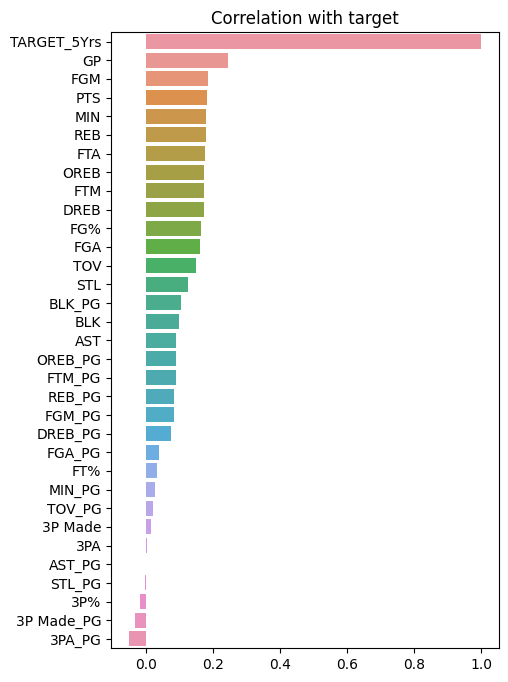

In [20]:
plt.figure(figsize=(5, 8))
corr_target = corr[target].sort_values(ascending=False)
sns.barplot(x=corr_target.values, y=corr_target.index)
plt.title('Correlation with target')
plt.show()

## 3. Modelling

In [21]:
# split features & target

def split_features_target(df, target):
    X = df.drop(columns=target)
    y = df[target]
    return X, y



X_train, y_train = split_features_target(train, target)
X_val, y_val = split_features_target(val, target)


In [22]:
# seperate target

def separate_target(data_train, data_test, target):
    X_train = data_train.drop(columns=target)
    y_train = data_train[target]
    X_test = data_test.drop(columns=target)
    y_test = data_test[target]
    
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = separate_target(train, val, 'TARGET_5Yrs')


In [26]:
def report_result(model_name, y_test_pred, y_test_pred_proba):
    # roc curve
    plt.figure(figsize=(5, 5))
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    auc = roc_auc_score(y_test, y_test_pred_proba)
    plt.title('ROC Curve of {} (AUROC={:.4f})'.format(model_name, auc))
    plt.show()


def fit_and_evaluate(model, X_train=X_train, y_train=y_train):
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    report_result(model.__class__.__name__, y_test_pred, y_test_pred_proba)

### 3.1 XGBoost

In [27]:
!pip install xgboost
import xgboost as xgb

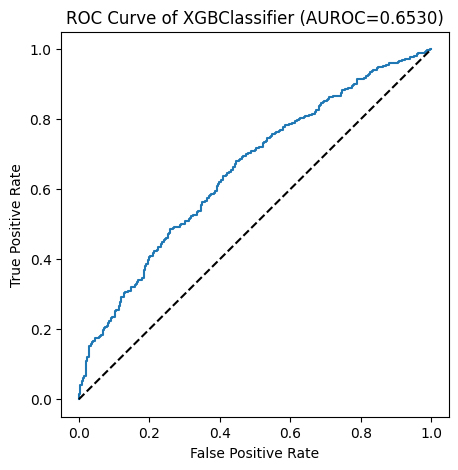

In [28]:
# xgboost base
model = xgb.XGBClassifier()
fit_and_evaluate(model)


In [29]:
joblib.dump(model, "../models/xgboost_model_before_hypertuning")

['../models/xgboost_model_before_hypertuning']

#### 3.2 Hypertuning Using GridSearch

In [30]:
param_space = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 11, 13],
}
model = xgb.XGBClassifier()
grid = GridSearchCV(model, param_grid=param_space, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
print('Best parameters found:', grid.best_params_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters found: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


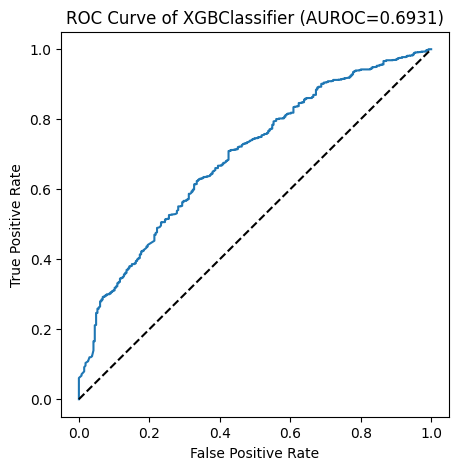

In [31]:
model = grid.best_estimator_
fit_and_evaluate(model)

In [32]:
joblib.dump(model, "../models/xgboost_model_after_hypertuning")

['../models/xgboost_model_after_hypertuning']